<a href="https://colab.research.google.com/github/harsh-hks-580/FireProof/blob/main/modelfire_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras.backend as K

from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import Xception, InceptionV3, MobileNetV2, NASNetMobile, EfficientNetB0    #Xception 299, inceptionV2 299, Nasnet 224
from tensorflow.keras.activations import *
from tensorflow.keras.losses import *
from keras.callbacks import LearningRateScheduler

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import joblib
from keras.preprocessing.image import load_img
from keras.preprocessing import image

%matplotlib inline

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
train_dir = '/content/drive/MyDrive/Fire-Safety-Dataset/Train/'
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
                                  )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    subset = 'training',
                                                    shuffle = True)

validation_dir = train_dir
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split = 0.1
                                        )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=16,
                                                              subset = 'validation',
                                                              class_mode ='categorical',
                                                              target_size=(224,224),
                                                              shuffle = True)

test_dir = '/content/drive/MyDrive/Fire-Safety-Dataset/Test/'
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  )
test_generator =test_datagen.flow_from_directory(test_dir,
                                                              batch_size=16,
                                                              class_mode ='categorical',
                                                              target_size=(224,224),
                                                              shuffle = True)

Found 8795 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Found 1472 images belonging to 2 classes.


In [ ]:
base_model = MobileNetV2(
    include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), classes = 2
)

fine_tune_at = int (len(base_model.layers)*0.7)
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64,activation='relu'))
model.add(Dense(2,activation='softmax'))
#tf.keras.models.load_model('suryafire.h5')
model.compile(optimizer = Adam(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
flatten_1 (Flatten)          (None, 62720)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               8028288   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 10,294,658
Trainable params: 9,836,290
Non-trainable params: 458,368
_____________________________________

In [ ]:
labels = test_generator.classes
preds = model.predict(test_generator)
correct = 0
print(preds.shape)
for i in range(labels.size):
  ilabel = 1
  if preds[i][0] > preds[i][1]:
    ilabel = 0
  if labels[i] == ilabel :
    correct = correct + 1

print(correct/ (labels.size))

(1472, 2)
0.8002717391304348


In [ ]:
correct = 0
for i in range(92) :
  test_x, test_y = test_generator.__getitem__(i)
  preds = model.predict(test_x)
  for i in range(preds.shape[0]):
    if np.argmax(preds[i]) == np.argmax(test_y[i]):
      correct += 1
print( correct/ test_generator.n)

0.8002717391304348


In [ ]:
filepath= 'suryafire.h5'  
my_callbacks = [
  ReduceLROnPlateau(
    monitor='val_acc', factor=0.5, patience=3, verbose=True,
    mode='auto', min_delta=0.000001, cooldown=0, min_lr=0 
  ), 
  ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=True, mode= 'min')]

In [ ]:
history = model.fit(train_generator,
                    shuffle = True,
                    epochs=10,
                    workers = 8,
                    verbose=True,
                    validation_data=validation_generator,
                    callbacks=my_callbacks)

Epoch 1/10
550/550 [==============================] - 110s 192ms/step - loss: 0.4714 - acc: 0.7739 - val_loss: 0.0983 - val_acc: 0.9672
Epoch 2/10
550/550 [==============================] - 107s 192ms/step - loss: 0.1546 - acc: 0.9437 - val_loss: 0.0725 - val_acc: 0.9723
Epoch 3/10
550/550 [==============================] - 106s 191ms/step - loss: 0.1119 - acc: 0.9601 - val_loss: 0.0605 - val_acc: 0.9775
Epoch 4/10
550/550 [==============================] - 107s 192ms/step - loss: 0.0884 - acc: 0.9674 - val_loss: 0.0591 - val_acc: 0.9764
Epoch 5/10
550/550 [==============================] - 106s 191ms/step - loss: 0.0774 - acc: 0.9734 - val_loss: 0.0834 - val_acc: 0.9775
Epoch 6/10
550/550 [==============================] - 106s 190ms/step - loss: 0.0702 - acc: 0.9759 - val_loss: 0.0766 - val_acc: 0.9764

Epoch 00006: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 7/10
550/550 [==============================] - 106s 190ms/step - loss: 0.0606 - acc: 0.9781 - va

In [ ]:
labels = test_generator.classes
preds = model.predict(test_generator)
correct = 0
print(preds.shape)
for i in range(labels.size):
  ilabel = 1
  if preds[i][0] > preds[i][1]:
    ilabel = 0
  if labels[i] == ilabel :
    correct = correct + 1

print(correct/ (labels.size))

(1472, 2)
0.670516304347826


[0.8673110008239746, 0.9479249715805054, 0.9606594443321228, 0.9696418642997742, 0.973393976688385, 0.9764639139175415, 0.9803297519683838, 0.9854462742805481, 0.9849914908409119, 0.9856736660003662]
[0.9672130942344666, 0.9723360538482666, 0.9774590134620667, 0.9764344096183777, 0.9774590134620667, 0.9764344096183777, 0.9774590134620667, 0.9774590134620667, 0.9846311211585999, 0.9836065769195557]


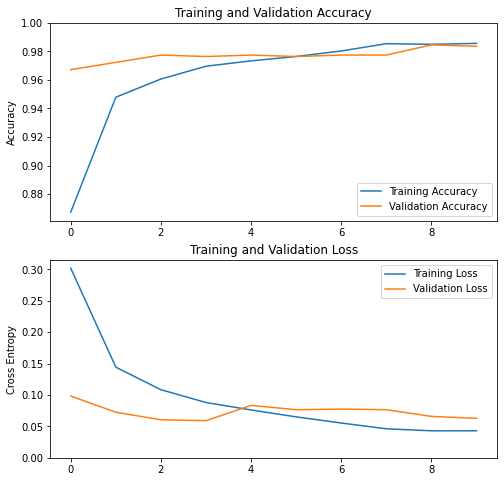

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
def Branch1(x):
  y= Conv2D(filters= 28 , kernel_size= (1,1),input_shape=(54,54,32),
                    padding= "valid" ,activation='linear', use_bias= True) (x)
  y= Conv2D(filters= 28 , kernel_size= (3,3),
                    padding= "valid" ,activation='linear', use_bias= True) (y)
  y= (MaxPooling2D(pool_size=(2, 2), padding='valid'))(y)
  y= Conv2D(filters= 56 , kernel_size= (3,3),
                    padding= "valid" ,activation='linear', use_bias= True) (y)
  return y

def Branch2(x):
  y= Conv2D(filters= 28 , kernel_size= (1,1), input_shape=(54,54,32),
                    padding= "valid" ,activation='relu', use_bias= True)(x)
  y= Conv2D(filters= 28 , kernel_size= (4,1),
                    padding= "valid" ,activation='relu', use_bias= True) (y)
  y= Conv2D(filters= 28 , kernel_size= (1,4),
                    padding= "valid" ,activation='relu', use_bias= True) (y)
  y= (MaxPooling2D(pool_size=(2, 2), padding='valid'))(y)
  y= Conv2D(filters= 56 , kernel_size= (2,2),
                    padding= "valid" ,activation='relu', use_bias= True) (y)
  
  return y

In [ ]:
input= tf.keras.Input((224, 224, 3))
deepFire=Conv2D(filters= 16 , kernel_size= (3,3), 
                    padding= "valid" ,activation='relu')(input)
deepFire=(AveragePooling2D(pool_size=(3, 3), padding='valid'))(deepFire)
deepFire=(Dropout(0.2))(deepFire)

deepFire=Conv2D(filters= 32 , kernel_size= (3,3), 
                    padding= "valid" ,activation='relu')(input)
deepFire=(AveragePooling2D(pool_size=(3, 3), padding='valid'))(deepFire)
deepFire=(Dropout(0.2))(deepFire)

deepFire=Conv2D(filters= 64 , kernel_size= (3,3), 
                    padding= "valid" ,activation='relu')(input)
deepFire=(AveragePooling2D(pool_size=(3, 3), padding='valid'))(deepFire)
deepFire=(Dropout(0.2))(deepFire)


deepFire=(Flatten())(deepFire)
deepFire=(Dense(256, activation= 'relu'))(deepFire)
deepFire=(Dropout(0.2))(deepFire)
deepFire=(Dense(128, activation='relu'))(deepFire)
deepFire_out=(Dense(2, activation= 'softmax'))(deepFire)

In [ ]:
deepFire = tf.keras.models.Model(input,deepFire_out)
deepFire.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])
deepFire.summary()
#plot_model(deepFire, show_shapes=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
average_pooling2d_2 (Average (None, 74, 74, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 74, 74, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 350464)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               89719040  
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0     

In [ ]:
labels = test_generator.classes
preds = deepFire.predict(test_generator)
correct = 0
for i in range(labels.size):
  ilabel = 1
  if preds[i][0] > preds[i][1]:
    ilabel = 0
  if labels[i] == ilabel :
    correct = correct + 1

print(correct/ (labels.size))

0.4008152173913043


In [ ]:
correct = 0
for i in range(92) :
  test_x, test_y = test_generator.__getitem__(i)
  preds = deepFire.predict(test_x)
  for i in range(preds.shape[0]):
    if np.argmax(preds[i]) == np.argmax(test_y[i]):
      correct += 1
print( correct/ test_generator.n)

0.3383152173913043


In [ ]:
filepath= 'suryafirecustom.h5'  
my_callbacks = [
  ReduceLROnPlateau(
    monitor='val_acc', factor=0.5, patience=3, verbose=True,
    mode='auto', min_delta=0.000001, cooldown=0, min_lr=0 
  ), 
  ModelCheckpoint(
    filepath, monitor='val_loss', verbose=0, save_best_only=True, mode= 'min')]

In [ ]:
history = deepFire.fit(train_generator,
                    shuffle = True,
                    epochs=5,
                    workers = 8,
                    verbose=True,
                    validation_data=validation_generator,
                    callbacks=my_callbacks)

Epoch 1/5
550/550 [==============================] - 106s 189ms/step - loss: 1.4464 - acc: 0.6762 - val_loss: 0.5160 - val_acc: 0.7910
Epoch 2/5
550/550 [==============================] - 106s 189ms/step - loss: 0.5325 - acc: 0.7655 - val_loss: 0.3782 - val_acc: 0.8156
Epoch 3/5
550/550 [==============================] - 106s 190ms/step - loss: 0.4774 - acc: 0.7961 - val_loss: 0.4093 - val_acc: 0.8709
Epoch 4/5
550/550 [==============================] - 103s 186ms/step - loss: 0.4697 - acc: 0.8063 - val_loss: 0.3329 - val_acc: 0.8863
Epoch 5/5
550/550 [==============================] - 105s 189ms/step - loss: 0.4465 - acc: 0.8179 - val_loss: 0.3155 - val_acc: 0.8883


[0.7137009501457214, 0.773393988609314, 0.7960204482078552, 0.8125070929527283, 0.8193291425704956]
[0.7909836173057556, 0.8155737519264221, 0.8709016442298889, 0.8862704634666443, 0.8883196711540222]


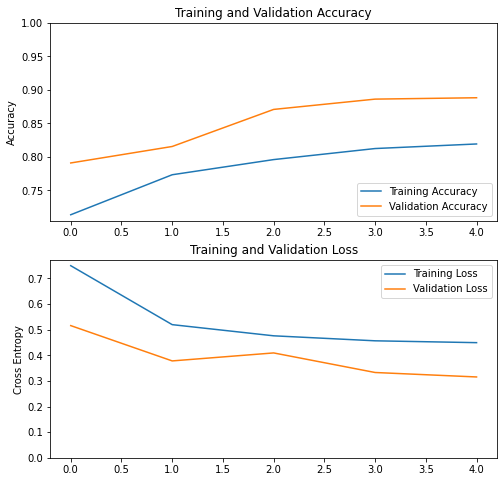

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

print(acc)
print(val_acc)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
##hks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import numpy as np
import pandas as pd
import os
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras as K
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras import activations
from keras.callbacks import LearningRateScheduler as lrschduler

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from keras.preprocessing.image import load_img
from keras.preprocessing import image

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
train_dir = '/content/drive/MyDrive/Fire-Safety-Dataset/Train/'
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
                                  )
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(64,64),
                                                    subset = 'training',
                                                    shuffle = True)

validation_dir = train_dir
validation_datagen = ImageDataGenerator(rescale=1.0/255,
                                        validation_split = 0.1
                                        )
validation_generator = validation_datagen.flow_from_directory(validation_dir,
                                                              batch_size=32,
                                                              subset = 'validation',
                                                              class_mode ='categorical',
                                                              target_size=(64,64),
                                                              shuffle = True)

test_dir = '/content/drive/MyDrive/Fire-Safety-Dataset/Test/'
test_datagen = ImageDataGenerator(rescale = 1./255,
                                  )
test_generator =test_datagen.flow_from_directory(test_dir,
                                                              batch_size=32,
                                                              class_mode ='categorical',
                                                              target_size=(64,64),
                                                              shuffle = True)

Found 8795 images belonging to 2 classes.
Found 976 images belonging to 2 classes.
Found 1472 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(64,64,3)))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    shuffle = True,
                    epochs=10,
                    workers = 8,
                    verbose=True,
                    validation_data=validation_generator
                    )

Epoch 1/10
275/275 [==============================] - 459s 2s/step - loss: 0.6513 - accuracy: 0.6014 - val_loss: 0.5807 - val_accuracy: 0.5943
Epoch 2/10
275/275 [==============================] - 61s 220ms/step - loss: 0.4988 - accuracy: 0.7647 - val_loss: 0.5702 - val_accuracy: 0.6855
Epoch 3/10
275/275 [==============================] - 63s 221ms/step - loss: 0.4421 - accuracy: 0.8045 - val_loss: 0.3109 - val_accuracy: 0.8760
Epoch 4/10
275/275 [==============================] - 63s 220ms/step - loss: 0.3813 - accuracy: 0.8423 - val_loss: 0.2412 - val_accuracy: 0.8986
Epoch 5/10
275/275 [==============================] - 62s 221ms/step - loss: 0.3518 - accuracy: 0.8526 - val_loss: 0.2794 - val_accuracy: 0.8832
Epoch 6/10
275/275 [==============================] - 61s 219ms/step - loss: 0.3442 - accuracy: 0.8570 - val_loss: 0.2996 - val_accuracy: 0.8719
Epoch 7/10
275/275 [==============================] - 61s 217ms/step - loss: 0.3311 - accuracy: 0.8593 - val_loss: 0.2155 - val_accu

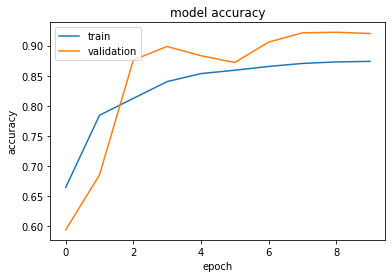

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(test_generator, batch_size=32,verbose = True)

46/46 [==============================] - 6s 134ms/step - loss: 0.2724 - accuracy: 0.8655


[0.2724178433418274, 0.86548912525177]

In [ ]:
def check_area(image):
  frame = image
  frame = cv2.resize(frame, (500, 500))
  hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
  hl = 0
  sl = 0
  vl = 246
  hh = 255
  sh = 255
  vh = 255

  low = np.array([hl, sl, vl])
  high = np.array([hh, sh, vh])

  mask = cv2.inRange(hsv, low, high)

  _, thresh = cv2.threshold(mask, 125, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  totalArea = 0
  for i in range(0, len(contours)):
      approx = cv2.approxPolyDP(contours[i], 0.01 * cv2.arcLength(contours[i], True), True)
      area = cv2.contourArea(contours[i])
      totalArea = totalArea + area
      cv2.drawContours(frame, contours, i, (0, 255, 0), 2)

  #cv2_imshow( mask)
  #cv2_imshow(frame)
  t = 1
  return (totalArea/2500)

def cost_calc(arr, image):
  cost=0
  if arr == 1 :
    cost = check_area(image)
  return cost

def fire(filename):
  imag = cv2.imread(filename)
  #cv2_imshow(imag)

  image_path = filename
  img = load_img(image_path, target_size = (64,64))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = x/255
  p = model.predict(x)
  #print(p)
  #print(labels[i])
  i = np.argmax(p,1).squeeze()
  return cost_calc(i, imag)